# Cell 1: 노트북 개요

## 04_ssl_pretraining.ipynb - Self-supervised 사전학습

이 노트북에서는 KITTI 데이터로 SimCLR 기반 Self-supervised 학습을 수행합니다.

### 목표
1. SimCLR 아키텍처 구현
2. Contrastive Loss (NT-Xent) 구현
3. KITTI 데이터로 사전학습
4. 학습된 표현 품질 평가

### 참고 논문
- **SimCLR** (Chen et al., ICML 2020): A Simple Framework for Contrastive Learning of Visual Representations
- **NT-Xent Loss**: Normalized Temperature-scaled Cross Entropy Loss

### GPU 최적화 (GTX 1080Ti 11GB)
- Batch size: 16
- Mixed Precision (FP16)
- ResNet-50 backbone

In [12]:
# Cell 1: 라이브러리 및 설정

import sys
import os
import json
import logging
import numpy as np
from pathlib import Path
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import torchvision.transforms as T
import torchvision.models as models

# 프로젝트 루트
PROJECT_ROOT = Path().absolute().parent
sys.path.insert(0, str(PROJECT_ROOT))

# 로깅 설정
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# GPU 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Device: cuda
GPU: NVIDIA GeForce GTX 1080 Ti
VRAM: 11.0 GB


In [13]:
# Cell 1-1: 사용자 설정 파라미터
# ==============================================
# 이 셀에서 모든 주요 하이퍼파라미터를 설정합니다.
# ==============================================

# 학습 설정
EPOCHS = 10                    # 학습 에폭 수 (기본: 100, 테스트: 10)
BATCH_SIZE = 16                # 배치 크기 (1080Ti 11GB 권장: 16)
LEARNING_RATE = 0.001          # 학습률
WEIGHT_DECAY = 0.0001          # 가중치 감쇠
TEMPERATURE = 0.5              # NT-Xent Loss 온도

# 데이터 설정
MAX_TRAIN_SAMPLES = 10000      # 학습 샘플 수 제한 (전체 사용: None)
MAX_VAL_SAMPLES = 2000         # 검증 샘플 수 제한

# DataLoader 설정
NUM_WORKERS = 0                # Windows Jupyter: 0 권장
PIN_MEMORY = True              # GPU 사용 시 True

# Mixed Precision
USE_AMP = True                 # FP16 학습

print("✅ 사용자 설정 로드 완료")
print(f"  EPOCHS: {EPOCHS}")
print(f"  BATCH_SIZE: {BATCH_SIZE}")
print(f"  NUM_WORKERS: {NUM_WORKERS}")

✅ 사용자 설정 로드 완료
  EPOCHS: 10
  BATCH_SIZE: 16
  NUM_WORKERS: 0


In [14]:
# Cell 2: 학습 설정 로드

import yaml

# 설정 파일 로드
training_config_path = PROJECT_ROOT / 'config' / 'training_config.yaml'
with open(training_config_path, 'r', encoding='utf-8') as f:
    training_config = yaml.safe_load(f)

model_config_path = PROJECT_ROOT / 'config' / 'model_config.yaml'
with open(model_config_path, 'r', encoding='utf-8') as f:
    model_config = yaml.safe_load(f)

# SSL 학습 설정
SSL_CONFIG = training_config['ssl_training']
print("Self-supervised 학습 설정:")
for key, value in SSL_CONFIG.items():
    print(f"  {key}: {value}")

Self-supervised 학습 설정:
  batch_size: 16
  learning_rate: 0.001
  weight_decay: 0.0001
  epochs: 100
  warmup_epochs: 10
  mixed_precision: True
  temperature: 0.5
  augmentation: {'resize': [224, 224], 'random_crop': True, 'color_jitter': 0.8, 'gaussian_blur': True, 'horizontal_flip': True}


In [15]:
# Cell 3: KITTI 데이터셋 로드

import cv2

# 데이터셋 정보 로드
dataset_info_path = PROJECT_ROOT / 'dataset' / 'kitti_dataset_info.json'

if dataset_info_path.exists():
    with open(dataset_info_path, 'r') as f:
        kitti_info = json.load(f)
    print(f"KITTI 시퀀스: {kitti_info['total_sequences']}개")
    print(f"Train 시퀀스: {kitti_info['train_sequences']}개")
    print(f"Val 시퀀스: {kitti_info['val_sequences']}개")
else:
    print("⚠️ kitti_dataset_info.json이 없습니다.")
    print("03_kitti_exploration.ipynb를 먼저 실행해주세요.")
    kitti_info = {'train_paths': [], 'val_paths': []}

KITTI 시퀀스: 50개
Train 시퀀스: 40개
Val 시퀀스: 10개


In [16]:
# Cell 4: SimCLR 데이터 증강 파이프라인

class SimCLRAugmentation:
    """
    SimCLR 스타일 데이터 증강
    
    논문: Chen et al., "A Simple Framework for Contrastive Learning" (ICML 2020)
    핵심: 강력한 augmentation이 contrastive learning 성능의 핵심
    """
    
    def __init__(self, size=224):
        self.transform = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop(size, scale=(0.2, 1.0)),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomApply([
                T.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            T.RandomGrayscale(p=0.2),
            T.RandomApply([
                T.GaussianBlur(kernel_size=23)
            ], p=0.5),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
        ])
    
    def __call__(self, x):
        return self.transform(x), self.transform(x)

print("✅ SimCLRAugmentation 정의 완료")

✅ SimCLRAugmentation 정의 완료


In [17]:
# Cell 5: KITTI 데이터셋 클래스

class KITTIContrastiveDataset(Dataset):
    """
    KITTI Contrastive Learning 데이터셋
    
    각 이미지에 두 가지 다른 augmentation을 적용하여
    positive pair를 생성
    """
    
    def __init__(self, sequence_paths, augmentation=None, max_samples=None):
        self.augmentation = augmentation or SimCLRAugmentation()
        self.image_paths = []
        
        # 모든 이미지 경로 수집
        for seq_path in sequence_paths:
            seq_dir = Path(seq_path)
            if seq_dir.exists():
                images = list(seq_dir.glob('*.png')) + list(seq_dir.glob('*.jpg'))
                self.image_paths.extend([str(p) for p in images])
        
        # 최대 샘플 수 제한 (메모리 관리)
        if max_samples and len(self.image_paths) > max_samples:
            np.random.shuffle(self.image_paths)
            self.image_paths = self.image_paths[:max_samples]
        
        print(f"데이터셋 크기: {len(self.image_paths):,}")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # 이미지 로드
        img = cv2.imread(self.image_paths[idx])
        if img is None:
            # 로드 실패 시 다른 이미지 반환
            return self.__getitem__((idx + 1) % len(self))
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # 두 가지 증강 적용
        x1, x2 = self.augmentation(img)
        
        return x1, x2

print("✅ KITTIContrastiveDataset 정의 완료")

✅ KITTIContrastiveDataset 정의 완료


In [18]:
# Cell 6: SimCLR 모델 정의

class SimCLR(nn.Module):
    """
    SimCLR 모델
    
    구조:
    1. Encoder (ResNet-50): 이미지 → 특징 벡터
    2. Projection Head: 특징 → contrastive space로 매핑
    
    논문: Chen et al., ICML 2020
    """
    
    def __init__(self, base_encoder='resnet50', projection_dim=128):
        super().__init__()
        
        # Backbone encoder
        if base_encoder == 'resnet50':
            self.encoder = models.resnet50(pretrained=True)
            self.feature_dim = self.encoder.fc.in_features  # 2048
            self.encoder.fc = nn.Identity()  # FC 레이어 제거
        elif base_encoder == 'resnet34':
            self.encoder = models.resnet34(pretrained=True)
            self.feature_dim = self.encoder.fc.in_features  # 512
            self.encoder.fc = nn.Identity()
        else:
            raise ValueError(f"Unknown encoder: {base_encoder}")
        
        # Projection head (MLP)
        self.projection_head = nn.Sequential(
            nn.Linear(self.feature_dim, self.feature_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.feature_dim, projection_dim)
        )
        
        print(f"SimCLR 모델 생성: {base_encoder}, feature_dim={self.feature_dim}")
    
    def forward(self, x):
        # Encoder로 특징 추출
        h = self.encoder(x)
        
        # Projection head로 매핑
        z = self.projection_head(h)
        
        return h, z
    
    def get_encoder(self):
        """학습된 encoder 반환 (downstream task용)"""
        return self.encoder

print("✅ SimCLR 모델 정의 완료")

✅ SimCLR 모델 정의 완료


In [19]:
# Cell 7: NT-Xent Loss (Contrastive Loss)

class NTXentLoss(nn.Module):
    """
    Normalized Temperature-scaled Cross Entropy Loss
    
    같은 이미지의 두 augmentation은 가깝게,
    다른 이미지는 멀게 학습
    
    수식: L = -log(exp(sim(z_i, z_j)/τ) / Σ exp(sim(z_i, z_k)/τ))
    
    논문: Chen et al., ICML 2020
    """
    
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature
    
    def forward(self, z1, z2):
        """
        Args:
            z1, z2: projection outputs (batch_size, projection_dim)
        """
        batch_size = z1.shape[0]
        
        # L2 정규화
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)
        
        # 모든 쌍에 대한 유사도 계산
        representations = torch.cat([z1, z2], dim=0)  # (2*batch_size, dim)
        similarity_matrix = torch.mm(representations, representations.T)  # (2N, 2N)
        
        # 자기 자신과의 유사도는 제외
        mask = torch.eye(2 * batch_size, device=z1.device).bool()
        similarity_matrix = similarity_matrix.masked_fill(mask, -float('inf'))
        
        # Positive pairs의 인덱스
        # z1[i]와 z2[i]는 positive pair
        positives = torch.cat([
            torch.diag(similarity_matrix[:batch_size, batch_size:]),  # z1 <-> z2
            torch.diag(similarity_matrix[batch_size:, :batch_size])   # z2 <-> z1
        ])
        
        # 온도 스케일링
        similarity_matrix = similarity_matrix / self.temperature
        positives = positives / self.temperature
        
        # Contrastive loss 계산
        # 각 샘플에 대해 positive를 찾는 cross entropy
        logits = torch.cat([
            positives.unsqueeze(1),
            similarity_matrix.view(2 * batch_size, -1)
        ], dim=1)
        
        labels = torch.zeros(2 * batch_size, dtype=torch.long, device=z1.device)
        
        loss = F.cross_entropy(logits, labels)
        
        return loss

print("✅ NTXentLoss 정의 완료")

✅ NTXentLoss 정의 완료


In [20]:
# Cell 8: 학습 설정 (수정됨)

# Cell 1-1에서 정의한 파라미터 사용
# 데이터셋 생성
train_paths = kitti_info.get('train_paths', [])
val_paths = kitti_info.get('val_paths', [])

if train_paths:
    train_dataset = KITTIContrastiveDataset(
        train_paths, 
        augmentation=SimCLRAugmentation(224),
        max_samples=MAX_TRAIN_SAMPLES
    )
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True,
        num_workers=NUM_WORKERS,      # Windows fix
        pin_memory=PIN_MEMORY,
        drop_last=True
    )
    print(f"Train DataLoader: {len(train_loader)} batches")
else:
    print("⚠️ Train 데이터가 없습니다.")
    train_loader = None

if val_paths:
    val_dataset = KITTIContrastiveDataset(
        val_paths,
        augmentation=SimCLRAugmentation(224),
        max_samples=MAX_VAL_SAMPLES
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,      # Windows fix
        pin_memory=PIN_MEMORY
    )
    print(f"Val DataLoader: {len(val_loader)} batches")
else:
    val_loader = None

데이터셋 크기: 10,000
Train DataLoader: 625 batches
데이터셋 크기: 2,000
Val DataLoader: 125 batches


In [21]:
# Cell 9: 모델, 옵티마이저, 스케줄러 생성

# 모델
model = SimCLR(
    base_encoder=model_config['encoder']['type'],  # resnet50
    projection_dim=128
).to(device)

# 손실 함수
criterion = NTXentLoss(temperature=TEMPERATURE)

# 옵티마이저
optimizer = optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=SSL_CONFIG['weight_decay']
)

# 스케줄러 (Cosine Annealing)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
    eta_min=1e-6
)

# Mixed Precision
scaler = GradScaler() if USE_AMP else None

print(f"\n모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")
print(f"학습 가능 파라미터: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

SimCLR 모델 생성: resnet50, feature_dim=2048

모델 파라미터 수: 27,966,656
학습 가능 파라미터: 27,966,656


C:\Users\Administrator\AppData\Local\Temp\ipykernel_3260\2301023259.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if USE_AMP else None


In [22]:
# Cell 10: 학습 함수

def train_epoch(model, train_loader, criterion, optimizer, scaler, device):
    """한 에폭 학습"""
    model.train()
    total_loss = 0
    
    pbar = tqdm(train_loader, desc="Training")
    for x1, x2 in pbar:
        x1, x2 = x1.to(device), x2.to(device)
        
        optimizer.zero_grad()
        
        if scaler:  # Mixed Precision
            with autocast():
                _, z1 = model(x1)
                _, z2 = model(x2)
                loss = criterion(z1, z2)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            _, z1 = model(x1)
            _, z2 = model(x2)
            loss = criterion(z1, z2)
            
            loss.backward()
            optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    """검증"""
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for x1, x2 in val_loader:
            x1, x2 = x1.to(device), x2.to(device)
            
            _, z1 = model(x1)
            _, z2 = model(x2)
            loss = criterion(z1, z2)
            
            total_loss += loss.item()
    
    return total_loss / len(val_loader)

print("✅ 학습/검증 함수 정의 완료")

✅ 학습/검증 함수 정의 완료


In [23]:
# Cell 11: 학습 실행

# 학습 기록
history = {
    'train_loss': [],
    'val_loss': [],
    'lr': []
}

# 체크포인트 디렉토리
checkpoint_dir = PROJECT_ROOT / 'checkpoints' / 'ssl'
checkpoint_dir.mkdir(parents=True, exist_ok=True)

best_val_loss = float('inf')

if train_loader:
    print(f"\n{'='*50}")
    print(f"Self-supervised 학습 시작")
    print(f"{'='*50}")
    print(f"Epochs: {EPOCHS}")
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Learning rate: {LEARNING_RATE}")
    print(f"Temperature: {TEMPERATURE}")
    print(f"Mixed Precision: {USE_AMP}")
    print(f"{'='*50}\n")
    
    try:
        for epoch in range(EPOCHS):
            print(f"\nEpoch {epoch + 1}/{EPOCHS}")
            
            # 학습
            train_loss = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
            history['train_loss'].append(train_loss)
            
            # 검증
            if val_loader:
                val_loss = validate(model, val_loader, criterion, device)
                history['val_loss'].append(val_loss)
            else:
                val_loss = train_loss
                history['val_loss'].append(val_loss)
            
            # 학습률 기록
            current_lr = optimizer.param_groups[0]['lr']
            history['lr'].append(current_lr)
            
            # 스케줄러 업데이트
            scheduler.step()
            
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.6f}")
            
            # Best 모델 저장
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': val_loss,
                }, checkpoint_dir / 'best_ssl_model.pth')
                print(f"⭐ Best model saved!")
            
            # 주기적 저장
            if (epoch + 1) % 10 == 0:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': val_loss,
                }, checkpoint_dir / f'ssl_model_epoch_{epoch+1}.pth')
    
    except KeyboardInterrupt:
        print("\n\n⚠️ 학습 중단됨")
    
    print(f"\n학습 완료! Best Val Loss: {best_val_loss:.4f}")
else:
    print("⚠️ 학습 데이터가 없어 학습을 실행할 수 없습니다.")


Self-supervised 학습 시작
Epochs: 10
Batch size: 16
Learning rate: 0.001
Temperature: 0.5
Mixed Precision: True


Epoch 1/10


Training:   0%|          | 0/625 [00:00<?, ?it/s]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3260\3830164270.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 2.8256 | Val Loss: 2.8174 | LR: 0.001000
⭐ Best model saved!

Epoch 2/10


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 2.4956 | Val Loss: 2.6966 | LR: 0.000976
⭐ Best model saved!

Epoch 3/10


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 2.4007 | Val Loss: 2.6422 | LR: 0.000905
⭐ Best model saved!

Epoch 4/10


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 2.3419 | Val Loss: 2.5882 | LR: 0.000794
⭐ Best model saved!

Epoch 5/10


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 2.2906 | Val Loss: 2.5575 | LR: 0.000655
⭐ Best model saved!

Epoch 6/10


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 2.2404 | Val Loss: 2.4983 | LR: 0.000501
⭐ Best model saved!

Epoch 7/10


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 2.2010 | Val Loss: 2.5242 | LR: 0.000346

Epoch 8/10


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 2.1587 | Val Loss: 2.4210 | LR: 0.000207
⭐ Best model saved!

Epoch 9/10


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 2.1472 | Val Loss: 2.4482 | LR: 0.000096

Epoch 10/10


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 2.1211 | Val Loss: 2.4354 | LR: 0.000025

학습 완료! Best Val Loss: 2.4210


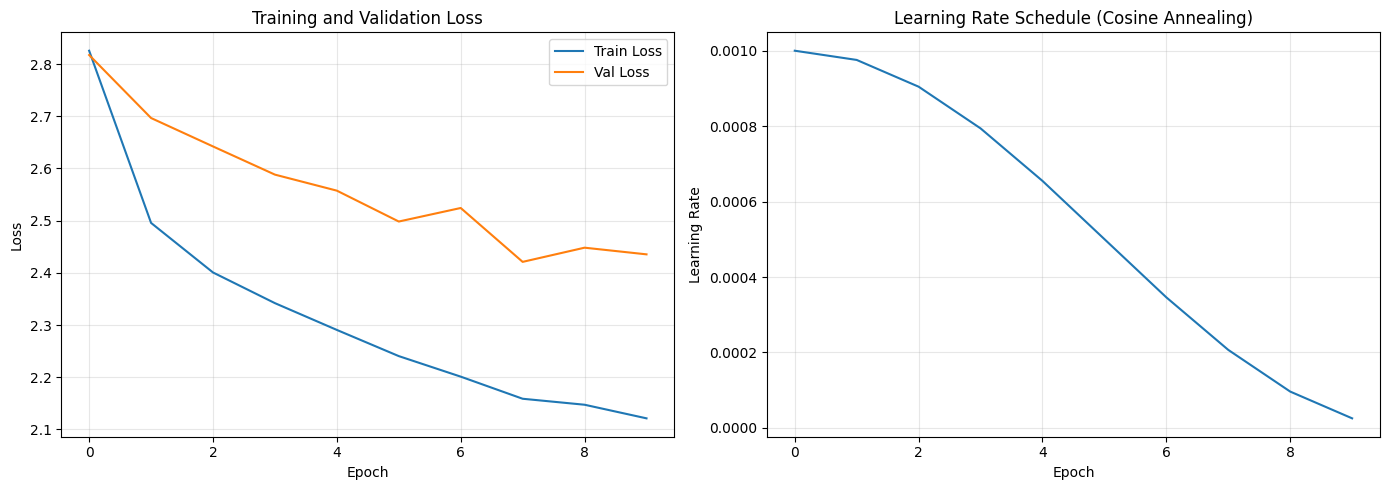

In [24]:
# Cell 12: 학습 곡선 시각화

if history['train_loss']:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[1].plot(history['lr'])
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Learning Rate')
    axes[1].set_title('Learning Rate Schedule (Cosine Annealing)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(checkpoint_dir / 'training_curves.png', dpi=150)
    plt.show()
else:
    print("학습 기록이 없습니다.")

특징 추출 중...
t-SNE 계산 중... (features shape: (500, 2048))


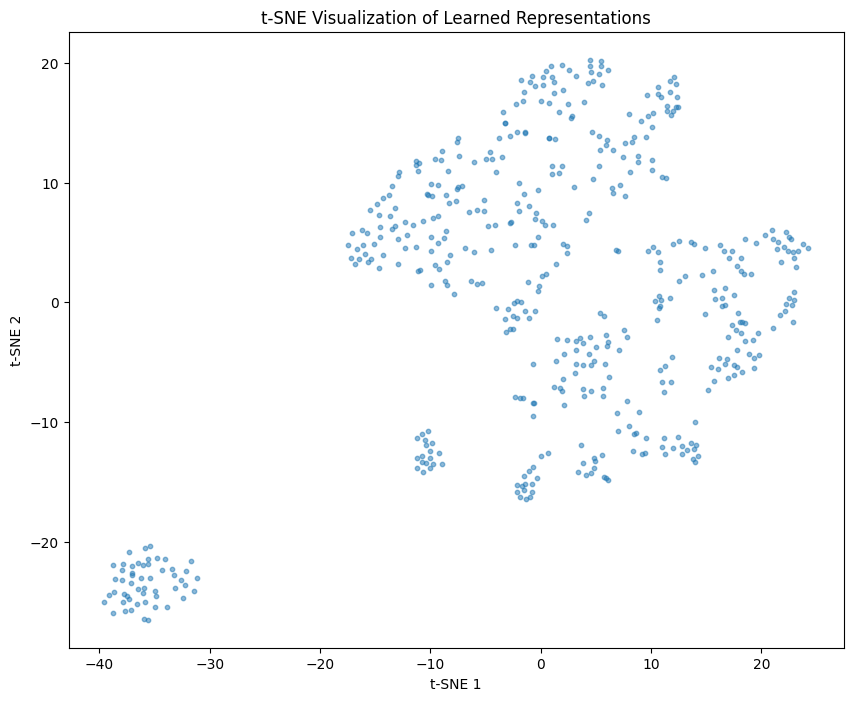

In [25]:
# Cell 13: 학습된 표현 품질 평가 (t-SNE)

from sklearn.manifold import TSNE

def extract_features(model, dataloader, device, max_samples=1000):
    """특징 벡터 추출"""
    model.eval()
    features = []
    
    with torch.no_grad():
        for x1, x2 in dataloader:
            x1 = x1.to(device)
            h, _ = model(x1)
            features.append(h.cpu().numpy())
            
            if len(features) * x1.shape[0] >= max_samples:
                break
    
    return np.vstack(features)[:max_samples]

if train_loader and len(history['train_loss']) > 0:
    print("특징 추출 중...")
    features = extract_features(model, train_loader, device, max_samples=500)
    
    print(f"t-SNE 계산 중... (features shape: {features.shape})")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings = tsne.fit_transform(features)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.5, s=10)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.title('t-SNE Visualization of Learned Representations')
    plt.savefig(checkpoint_dir / 'tsne_visualization.png', dpi=150)
    plt.show()
else:
    print("t-SNE 시각화를 위한 학습 데이터가 없습니다.")

In [26]:
# Cell 14: 체크포인트 저장 및 요약

# 최종 모델 저장
if len(history['train_loss']) > 0:
    final_checkpoint = {
        'model_state_dict': model.state_dict(),
        'encoder_state_dict': model.encoder.state_dict(),  # encoder만 따로 저장
        'config': {
            'base_encoder': model_config['encoder']['type'],
            'feature_dim': model.feature_dim,
            'projection_dim': 128
        },
        'training_config': SSL_CONFIG,
        'history': history,
        'best_val_loss': best_val_loss,
        'timestamp': datetime.now().isoformat()
    }
    
    torch.save(final_checkpoint, checkpoint_dir / 'ssl_final_model.pth')
    print(f"✅ 최종 모델 저장: {checkpoint_dir / 'ssl_final_model.pth'}")

print(f"\n{'='*50}")
print("Self-supervised 사전학습 완료")
print(f"{'='*50}")
print(f"체크포인트 디렉토리: {checkpoint_dir}")
print(f"Best Val Loss: {best_val_loss:.4f}" if 'best_val_loss' in dir() else "")
print(f"\n다음 단계: 05_bc_training.ipynb")

✅ 최종 모델 저장: c:\git\automotive\checkpoints\ssl\ssl_final_model.pth

Self-supervised 사전학습 완료
체크포인트 디렉토리: c:\git\automotive\checkpoints\ssl
Best Val Loss: 2.4210

다음 단계: 05_bc_training.ipynb


## Self-supervised 학습 요약

### 방법론: SimCLR
- **Contrastive Learning**: 같은 이미지의 다른 augmentation은 가깝게, 다른 이미지는 멀게
- **NT-Xent Loss**: Temperature-scaled cross entropy
- **강력한 Augmentation**: ColorJitter, GaussianBlur, RandomCrop 등

### 결과물
- `checkpoints/ssl/best_ssl_model.pth`: Best validation loss 모델
- `checkpoints/ssl/ssl_final_model.pth`: 최종 모델 (encoder 포함)

### 참고 논문

| 논문 | 핵심 아이디어 |
|------|---------------|
| SimCLR (Chen et al., 2020) | 강력한 augmentation + contrastive learning으로 라벨 없이 표현 학습 |
| MoCo (He et al., 2020) | Momentum encoder로 큰 negative pool 유지 |
| BYOL (Grill et al., 2020) | Negative sample 없이 자기 지도 학습 |